### CONFIGURATION

In [37]:
import pandas as pd
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import copy
import sys
import matplotlib.pyplot as plt
%matplotlib inline

In [38]:
# Hartwig imports
sys.path.append("/Users/peterpriestley/hmf/repos/scripts/analysisscripts") 
import analyseVCF as aVCF
import venn as vn

In [39]:
#CHROM SLICING
minChromFrac = 0
maxChromFrac = 26

In [40]:
# COMBINED VCF CONFIG
VCF_SAMPLE = "CPCT02040020"
VCF_PATH = "/Users/peterpriestley/hmf/analyses/rerunSamples/"
VCF_FILE_NAME = VCF_SAMPLE + "R_"+ VCF_SAMPLE + "T_merged_somaticsNEW.vcf"
SAMPLE_NAMES = {VCF_SAMPLE + 'T.mutect':'mutect', \
                VCF_SAMPLE + 'T.freebayes':'freebayes', \
                'TUMOR.strelka':'strelka', \
                'TUMOR.varscan':'varscan'}
# TRUTH SET
VCF_SAMPLE_TRUTH = VCF_SAMPLE
SAMPLE_NAMES_TRUTH = SAMPLE_NAMES
VCF_PATH_TRUTH = VCF_PATH
VCF_FILE_NAME_TRUTH = VCF_SAMPLE + "R_"+ VCF_SAMPLE + "T_merged_somaticsOLD.vcf"


### Functions

In [41]:
def filterByChromFrac(df):
    return df[(df.chromFrac > minChromFrac)&(df.chromFrac < maxChromFrac)]

In [42]:
def calculateTruth(df,dfTruth):
    df = pd.merge(df,dfTruth,how='left', left_index=True,right_index=True,suffixes=('', '_Truth'))
    df['hasTP'] = False
    df['hasFP'] = False
    for columnName in list(df):
        if columnName.endswith('allele'):
            df['hasTP'] = (df['hasTP'])|(df[columnName] != '')
            #df['hasTP'] = (df['hasTP']) | ((df[columnName[:-6]+'indelDiff'] == df['truth_indelDiff']) \
            #        & (~pd.isnull(df['truth_indelDiff']) & (df['variantType'] == 'INDEL'))) |((df[columnName] == df['truth_allele']) \
            #        & (df['variantType'] == 'SNP'))
            #df['hasFP'] = (df['hasFP']) | ((df[columnName[:-6]+'indelDiff'] != df['truth_indelDiff']) \
            #        & (df['variantType'] == 'INDEL') & (df[columnName[:-6]+'indelDiff'] != '')) |((df[columnName] != df['truth_allele']) \
            #        & (df['variantType'] == 'SNP') & (df[columnName] != ''))
    df['Truth'] = (df['hasTP']) &  (df['hasFP'] == False)
    return df

In [43]:
def calcuatePrecisionSensivityMatrix(df):
    outputdata = []
    for columnName in list(df):
        if columnName.endswith('allele') & ~columnName.endswith('_allele'):
            myCaller = columnName[:-6]
            variantTypes = df[(df[myCaller+'allele'] != '')].variantType.unique()
            for variantType in variantTypes:
                truePositives = len(df[(df[myCaller+'allele'] != '') & (df['Truth'] == True) &(df['variantType'] == variantType)])
                positives = len(df[(df[myCaller+'allele'] != '')&(df['variantType'] == variantType)])
                truthSet = len(dfTruth[dfTruth['variantType'] == variantType]) 
                falseNegatives = truthSet - truePositives
                if positives > 0:
                    outputdata.append([variantType, myCaller, truthSet,truePositives,positives-truePositives, falseNegatives, \
                                   round(truePositives/float(positives),4),round(truePositives/float(truthSet),4)])
    
    outputDF = pd.DataFrame(outputdata)
    outputDF.columns = (['variantType','caller','truthSet','truePositives','falsePositives','falseNegatives','precision','sensitivity'])
    return outputDF.sort_values(['variantType','caller'])

<h3> Load VCFs and Prepare DF

In [44]:
## LOAD BED
#bed = aVCF.loadBEDFile(BED_PATH,BED_FILE_NAME)

In [45]:
## LOAD TRUTH SET VCF
#truthBed = copy.deepcopy(bed)
dfTruth = aVCF.loadVaraintsFromVCF(VCF_PATH_TRUTH,VCF_FILE_NAME_TRUTH, \
                                   SAMPLE_NAMES_TRUTH,"Mix-in Truth Set",True)
dfTruth = filterByChromFrac(dfTruth)
#dfTruth.rename(columns={'70-30truthallele':'truth_allele','70-30truthindelDiff':'truth_indelDiff','70-30truthindelPos':'truth_indelPos'}, inplace=True)
#dfTruth = dfTruth[['chrom','pos','variantType','ref','truth_allele','truth_indelDiff','truth_indelPos']]
dfTruth = dfTruth.set_index(['chrom','pos'])

reading vcf file: CPCT02040020R_CPCT02040020T_merged_somaticsOLD.vcf
reading VCF File line: 100000
reading VCF File line: 200000
reading VCF File line: 300000
reading VCF File line: 400000
reading VCF File line: 500000
reading VCF File line: 600000
reading VCF File line: 700000
reading VCF File line: 800000
Number variants loaded: 843708


In [46]:
# LOAD SAMPLE VCF + match to truth set
#sampleBed = copy.deepcopy(bed)
dfProd = aVCF.loadVaraintsFromVCF(VCF_PATH,VCF_FILE_NAME,SAMPLE_NAMES,VCF_SAMPLE,True)
dfProd = filterByChromFrac(dfProd)
dfProd = dfProd.set_index(['chrom','pos'])
dfProd = calculateTruth(dfProd,dfTruth)

reading vcf file: CPCT02040020R_CPCT02040020T_merged_somaticsNEW.vcf
Number variants loaded: 54888


<h3> SLICE ANALYSIS

In [ ]:
# SLICE SETTINGS
SLICE_VCF_PATH = "/Users/peterpriestley/hmf/70-30slice/"
SLICE_VCF_FILE_NAME = "somatics.merged.vcf"
SLICE_SAMPLE_NAMES = SAMPLE_NAMES 

In [ ]:
sliceBed = copy.deepcopy(bed)

In [ ]:
dfSlice = aVCF.loadVaraintsFromVCF(SLICE_VCF_PATH,SLICE_VCF_FILE_NAME,SLICE_SAMPLE_NAMES,VCF_SAMPLE,True,True,sliceBed)
dfSlice = filterByChromFrac(dfSlice)
dfSlice = dfSlice.set_index(['chrom','pos'])
dfSlice = calculateTruth(dfSlice,dfTruth)

In [ ]:
dfSlice[(dfSlice['Truth']== False)].head(10)

### PRECISION + SENSITIVITY|

In [47]:
#PRECISION + SENSITIVITY by caller - PROD
dfProd['Truth']=~pd.isnull(dfProd.chromPos_Truth)
outputDF = calcuatePrecisionSensivityMatrix(dfProd)
outputDF

,variantType,caller,truthSet,truePositives,falsePositives,falseNegatives,precision,sensitivity
6,INDEL,freebayes,3727,643,1551,3084,0.2931,0.1725
1,INDEL,strelka,3727,352,55,3375,0.8649,0.0944
2,INDEL,varscan,3727,1134,1202,2593,0.4854,0.3043
5,SNP,freebayes,839981,5524,13643,834457,0.2882,0.0066
4,SNP,mutect,839981,10592,12145,829389,0.4658,0.0126
0,SNP,strelka,839981,9261,7247,830720,0.5610,0.0110
3,SNP,varscan,839981,6600,3989,833381,0.6233,0.0079


In [34]:
len(dfTruth)

54888

In [63]:
len(dfProd[(dfProd.Truth ==True)&(dfProd.variantType=="SNP")])

16245

In [55]:
dftemp = dfProd[(dfProd['variantType']!= "SMP")].reset_index()
pd.pivot_table(dftemp, values='pos', index=['variantType','numCallers'], columns=['Truth'], aggfunc='count')

Truth                   False  True 
variantType numCallers              
INDEL       1            2717   1249
            2              44    257
            3               1    122
SNP         1           31672   8155
            2            2415   2479
            3             166   3580
            4               6   2031

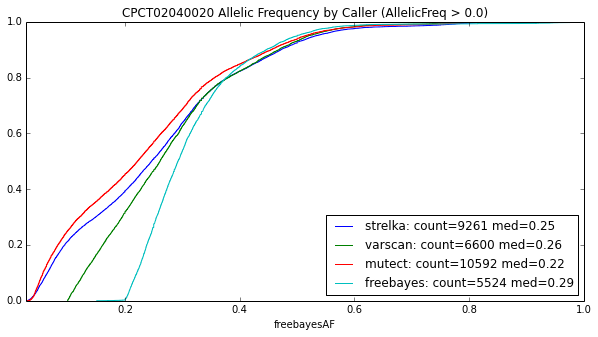

In [56]:
#Alllele Freq By Caller TRUE
snpdf = dfProd[(dfProd.variantType == 'SNP')&(dfProd.Truth ==True)]
for columnName in list(snpdf):
    if columnName.endswith('allele'):
        ser = snpdf[(snpdf[columnName] != '') &(snpdf[columnName[:-6] + 'AF'] > 0.0)][columnName[:-6] + 'AF']
        ser = ser.sort_values()
        #ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+": count="+str(ser.count())+" med="+str(round(ser.median(),2)))
        ser_cdf.plot(drawstyle='steps',legend=True,title=VCF_SAMPLE+" Allelic Frequency by Caller (AllelicFreq > 0.0)",figsize=[10,5])

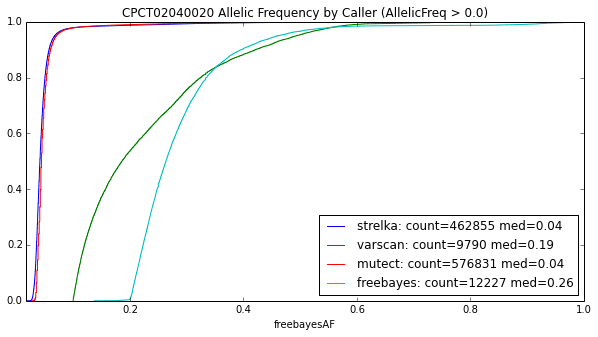

In [57]:
#Alllele Freq By Caller TRUE
snpdf = dfTruth[(dfTruth.variantType == 'SNP')]
for columnName in list(snpdf):
    if columnName.endswith('allele'):
        ser = snpdf[(snpdf[columnName] != '') &(snpdf[columnName[:-6] + 'AF'] > 0.0)][columnName[:-6] + 'AF']
        ser = ser.sort_values()
        #ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+": count="+str(ser.count())+" med="+str(round(ser.median(),2)))
        ser_cdf.plot(drawstyle='steps',legend=True,title=VCF_SAMPLE+" Allelic Frequency by Caller (AllelicFreq > 0.0)",figsize=[10,5])

In [29]:
len(snpdf)

823739

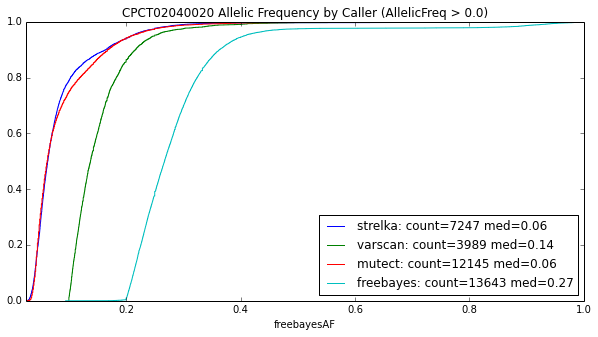

In [58]:
#Alllele Freq By Caller TRUE
snpdf = dfProd[(dfProd.variantType == 'SNP')&(dfProd.Truth ==False)]
for columnName in list(snpdf):
    if columnName.endswith('allele'):
        ser = snpdf[(snpdf[columnName] != '') &(snpdf[columnName[:-6] + 'AF'] > 0)][columnName[:-6] + 'AF']
        ser = ser.sort_values()
        #ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+": count="+str(ser.count())+" med="+str(round(ser.median(),2)))
        ser_cdf.plot(drawstyle='steps',legend=True,title=VCF_SAMPLE+" Allelic Frequency by Caller (AllelicFreq > 0.0)",figsize=[10,5])

# False Negative Analysis

In [ ]:
pd.options.display.max_rows = 200
caller = "varscan"
dfProd[(dfProd.Truth == True) &(dfProd[caller+'allele'] != '') & (dfProd.variantType == 'INDEL')][['ref',caller+'indelDiff',caller+'QS',caller+'AF','numCallers']]

In [ ]:
dfSlice[(dfSlice['Truth'] == True) & (dfSlice['freebayesallele'] != '') & (dfSlice.variantType == 'INDEL')]

In [ ]:
unfilteredBed = copy.deepcopy(bed)

In [ ]:
# SETTINGS
myCaller = 'varscan'
UNFILTERED_VCF_PATH = "/Users/peterpriestley/hmf/70-30slice/"
if myCaller == 'varscan':
    UNFILTERED_VCF_FILE_NAME = "varscan.snp.vcf"
    UNFILTERED_SAMPLE_NAMES = {"TUMOR":myCaller}
elif myCaller == 'freebayes':
    UNFILTERED_VCF_FILE_NAME = "freebayes.somatic.vcf"
    UNFILTERED_SAMPLE_NAMES = {'CPCT11111111T':myCaller}  
elif myCaller == 'strelka':
    UNFILTERED_VCF_FILE_NAME = "/strelka/results/all.somatic.snvs.vcf"
    UNFILTERED_SAMPLE_NAMES = {"TUMOR":myCaller}
elif myCaller == 'mutect':
    UNFILTERED_VCF_FILE_NAME = "mutect.vcf"
    UNFILTERED_SAMPLE_NAMES = {'CPCT11111111T':myCaller}


dfUnfiltered = aVCF.loadVaraintsFromVCF(UNFILTERED_VCF_PATH,UNFILTERED_VCF_FILE_NAME,UNFILTERED_SAMPLE_NAMES,VCF_SAMPLE,False,True,unfilteredBed)
dfUnfiltered['Truth']=dfUnfiltered.chromPos.isin(dfTruth['chromPos']) 
dfUnfiltered = dfUnfiltered[(dfUnfiltered.chromFrac > minChromFrac)&(dfUnfiltered.chromFrac < maxChromFrac)]

In [ ]:
dfTruth['inUnfiltered'+myCaller]=dfTruth.chromPos.isin(dfUnfiltered[dfUnfiltered[myCaller+'allele'] != '']['chromPos'])
dfTruth['inSlice']=dfTruth.chromPos.isin(dfSlice['chromPos'])

In [ ]:
#False Positives - pre-somatic
dfTruth[['inSlice','pos','inUnfiltered'+myCaller,'variantType']].groupby(['variantType','inUnfiltered'+myCaller]).agg('count')


In [ ]:
dfUnfiltered['inSlice'+myCaller]=dfUnfiltered.chromPos.isin(dfSlice[dfSlice[myCaller+'allele'] != '']['chromPos'])
dfUnfiltered['inSlice']=dfUnfiltered.chromPos.isin(dfSlice['chromPos'])

In [ ]:
dfUnfiltered[['inSlice'+myCaller,'pos','Truth','variantType','filter']].groupby(['variantType','inSlice'+myCaller,'Truth','filter']).agg('count')


In [ ]:

dfUnfiltered[(dfUnfiltered['Truth'] == True)&
            (dfUnfiltered['inSlice'+myCaller] == True)& 
             (dfUnfiltered.variantType == 'SNP') &
             (dfUnfiltered['filter'] != 'PETE')]['pos']

In [ ]:
#FALSE NEGATIVES IN UNFILTERED
dfUnfiltered[(dfUnfiltered['inSlice'+myCaller] == False)& 
             (dfUnfiltered[myCaller+'somaticGT'] != '2')&
             (dfUnfiltered.variantType == 'SNP') &
             (dfUnfiltered['filter'] != 'str10')].sort_values([myCaller+'QS'],ascending=False)

In [ ]:
dfSlice[dfSlice.pos>'37577400'].head(10)

In [ ]:
#FALSE POSITIVES`
dfUnfiltered[(dfUnfiltered['inSlice'+myCaller] == True) & (dfUnfiltered.variantType == 'SNP') &
             (dfUnfiltered['Truth'] == False)].sort_values([myCaller+'QS'],ascending=False)

<h3> SNP

In [ ]:
snpdf = dfProd[(dfProd.variantType == 'SNP')]

In [ ]:
snpdf[['Truth','pos']].groupby(['Truth']).agg('count')

In [ ]:
pd.pivot_table(snpdf, values='pos', index=['numCallers'], columns=['Truth'], aggfunc='count')

In [ ]:
vn.venn([snpdf[snpdf.mutectallele != '']['chromPos'], \
         snpdf[snpdf.strelkaallele != '']['chromPos'], \
        snpdf[snpdf.freebayesallele != '']['chromPos'], \
        snpdf[snpdf.varscanallele != '']['chromPos'] \
        ],['mutect','strelka','freebayes','varscan'],figsize=(6,6))

### <hd3> Indel Venn

In [ ]:
indeldf= dfProd[(dfProd.variantType == 'INDEL')]

In [ ]:
pd.pivot_table(indeldf, values='pos', index=['numCallers'], columns=['Truth'], aggfunc='count')

In [ ]:
vn.venn([indeldf[indeldf.strelkaallele != '']['chromPos'], \
        indeldf[indeldf.freebayesallele != '']['chromPos'], \
        indeldf[indeldf.varscanallele != '']['chromPos'] \
        ],['strelka','freebayes','varscan'],figsize=(6,6))

### <hd3> Read Depth

In [ ]:
for columnName in list(df):
    if columnName.endswith('allelicFreq'):
        df[df[columnName] != ''].hist(column=columnName,by="Truth",bins=40,figsize=(10,5))
        

In [ ]:
df[df.freebayesreadDepth != ''].hist(column="freebayesallelicFreq",by="Truth",bins=30)

In [ ]:
# INDELS BY CALLER BY TRUTH
caller = 'freebayes'
truths = indeldf.Truth.unique()
for truth in truths:
    ser = indeldf[(indeldf.Truth == truth) &(indeldf[caller+'allele'] != '')][caller + 'QS']
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=caller+" INDEL "+str(truth)+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=caller+" Qual Score CDF - INDELS",figsize=[15,6], xlim=[0,100],ylim=[0,1])

truths = snpdf.Truth.unique()
for truth in truths:
    ser = snpdf[(snpdf.Truth == truth) &(snpdf[caller+'allele'] != '')][caller + 'QS']
    ser = ser.sort_values()
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=caller+" SNP "+str(truth)+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=caller+"Qual Score CDF",figsize=[15,6],xlim=[0,100],ylim=[0,1])

<h3> Allelic Depth

In [ ]:
#Alllele Freq By Caller
for columnName in list(snpdf):
    if columnName.endswith('allele'):
        ser = snpdf[(snpdf[columnName] != '') &(snpdf[columnName[:-6] + 'allelicFreq'] > 0.0)][columnName[:-6] + 'allelicFreq']
        ser = ser.sort_values()
        #ser[len(ser)] = ser.iloc[-1]
        cum_dist = np.linspace(0.,1.,len(ser))
        ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
        ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by Caller (AllelicFreq > 0.0)",figsize=[15,6])

In [ ]:
# BY CALLER BY TRUTH
truths = snpdf.Truth.unique()
for truth in truths:
    for columnName in list(snpdf):
        if columnName.endswith('allele'):
            ser = snpdf[(snpdf.Truth == truth) &(snpdf[columnName] != '')][columnName[:-6] + 'allelicFreq']
            ser = ser.sort_values()
            #ser[len(ser)] = ser.iloc[-1]
            cum_dist = np.linspace(0.,1.,len(ser))
            ser_cdf = pd.Series(cum_dist, index=ser,name=columnName[:-6]+" "+str(truth)+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
            ser_cdf.plot(drawstyle='steps',legend=True,title=" Allelic Frequency by Caller and Truth",figsize=[15,6])

In [ ]:
#  BY VENN SEGMENT - Single Caller - FALSE POSITIVES
myCaller = 'freebayes'
vennSegments = snpdf[(snpdf[myCaller+'allele'] != '') & (snpdf.Truth == False)].vennSegment.unique()
for vennSegment in vennSegments:
    ser = snpdf[(snpdf.vennSegment == vennSegment) & (snpdf[myCaller+'allele'] != '') & (snpdf.Truth == False) ][myCaller+'allelicFreq']
    ser = ser.sort_values()
    ser[len(ser)] = ser.iloc[-1]
    cum_dist = np.linspace(0.,1.,len(ser))
    ser_cdf = pd.Series(cum_dist, index=ser,name=vennSegment+": c="+str(ser.count())+" m="+str(round(ser.median(),2)))
    ser_cdf.plot(drawstyle='steps',legend=True,title=myCaller+" FP by Venn Segment",figsize=[15,6])

### Allelic Depth Scatter Plot

In [ ]:
caller1 = 'varscan'
caller2 = 'strelka'
tempdf = df[(df[caller1+'allele']!='')&(df[caller2+'allele']!='')]
tempdf.head()
tempdf.plot.scatter(caller1+'allelicFreq',caller2+'allelicFreq' \
                        ,figsize=[6,6] \
                        ,title="Comparison of "+caller1+" and "+caller2+" Allelic Frequency" \
                        ,xlim=[0,1],ylim=[0,1])

<h3> RAINBOW CHARTS

In [ ]:
## RAINBOW
caller = 'freebayes'
plt.scatter(df[(df[caller+'allele']!='')& (df['Truth'] == True)&(df['chrom'] == '22')]['chromFrac'], \
            df[(df[caller+'allele']!='')& (df['Truth'] == True)&(df['chrom'] == '22')][caller+'allelicFreq'], \
            s=10, c='b', marker="s")

In [ ]:
## RAINBOW
caller = 'freebayes'
plt.scatter(df[(df[caller+'allele']!='')& (df['Truth'] == False)&(df['chrom'] == '22')]['chromFrac'], \
            df[(df[caller+'allele']!='')& (df['Truth'] == False)&(df['chrom'] == '22')][caller+'allelicFreq'], \
            s=10, c='b', marker="s")

<h3> Overlapping Analysis

In [ ]:
#NEEDS REFACTORING TO SUPPORT NEW DF FORMAT
'''
sorteddf = df.sort(['chromFrac'], ascending=1)
sorteddf['nextRef'] = sorteddf['ref'].shift(-2)
sorteddf['nextPos'] = sorteddf['pos'].shift(-2)
sorteddf['nextChrom'] = sorteddf['chrom'].shift(-2)
sorteddf['nextVT'] = sorteddf['variantType'].shift(-2)
sorteddf['nextAlleleTumor1'] = sorteddf['alleleTumor1'].shift(-2)
sorteddf['nextAlleleTumor2'] = sorteddf['alleleTumor2'].shift(-2)
sorteddf['nextVennSegment'] = sorteddf['vennSegment'].shift(-2)
sorteddf['lengthRef'] = sorteddf['ref'].str.len()
sorteddf['Dist2Next'] = -sorteddf['pos'].astype(int).diff(-2)

overlapdf = sorteddf[(sorteddf['lengthRef']+0>sorteddf['Dist2Next']) & (sorteddf['Dist2Next']>0)]
overlapdf.head(20)
'''

In [ ]:
#NEEDS REFACTORING TO SUPPORT NEW DF FORMAT
'''
filtereddf = overlapdf[(~overlapdf.vennSegment.isin(['freebayes','varscan','strelka1'])) \
                       & (overlapdf.vennSegment.str.contains('varscan')) \
                       #& (~overlapdf.nextVennSegment.str.contains('varscan')) \
                       & (overlapdf.variantType == 'INDEL') \
                       #& (overlapdf.variantSubType == 'DELETE')
                       & (overlapdf.variantType == overlapdf.nextVT)]
filtereddf[['nextVennSegment','vennSegment','variantType','nextVT','Dist2Next','lengthRef','ref','alleleTumor2', \
            'nextRef','nextAlleleTumor2','variantSubType','chrom','pos']].count()
'''